Saving GSE66939_leo1_H3K9me2_res25.wig.gz to GSE66939_leo1_H3K9me2_res25.wig (1).gz
Saving GSE66939_wt_H3K9me2_res25.wig.gz to GSE66939_wt_H3K9me2_res25.wig (1).gz
Available chromosomes: ['II', 'AB325691', 'MTR', 'III', 'I', 'MT']
Enter chromosome (e.g., I, II, III): II
WT range: 163 - 4539738
leo1Δ range: 113 - 4539763
Enter starting basepair: 1150000
Enter ending basepair: 1200000

🔷 WT triangle region (baseline+tolerance): 1,168,341 – 1,172,421 bp
✅ WT exact peak coordinate inside triangle: 1,171,992 bp, peak methylation strength A: 9.561025e-04

📍 Baselines:
WT baseline (mean of flat regions): 4.794062e-04
leo1Δ baseline (mean of flat regions): 4.845227e-04

🟠 leo1Δ peak regions (baseline + tol=1e-10):
  Peak 1: region 1,161,492–1,162,686 bp, exact peak at 1,161,731 bp, height=9.598038e-04
  Peak 2: region 1,167,983–1,168,365 bp, exact peak at 1,168,055 bp, height=9.454997e-04
  Peak 3: region 1,169,152–1,170,560 bp, exact peak at 1,169,749 bp, height=9.624643e-04


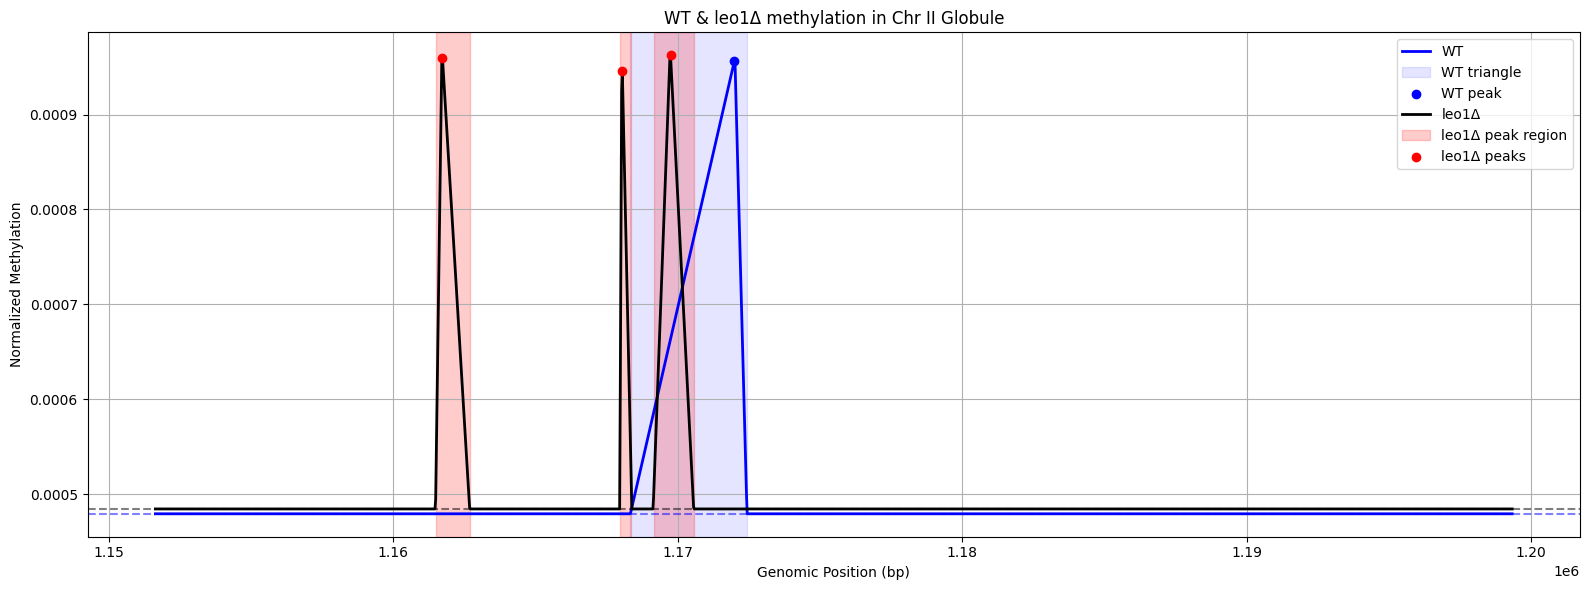

In [2]:
# ===============================
# 📦 1. Imports and Setup
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import gzip, re
from collections import defaultdict
from itertools import groupby
from operator import itemgetter
from google.colab import files

# ===============================
# 📁 2. Upload and Parse WIG Files
# ===============================
uploaded = files.upload()
wt_file = [f for f in uploaded if "wt" in f.lower()][0]
leo1_file = [f for f in uploaded if "leo1" in f.lower()][0]

def parse_wig_by_chrom(filename):
    chrom_data = defaultdict(list)
    with gzip.open(filename, 'rt') as f:
        current_chrom = None
        for line in f:
            line = line.strip()
            if line.startswith("variableStep"):
                m = re.search(r'chrom=([^\s]+)', line)
                if m: current_chrom = m.group(1)
            elif line and not line.startswith("track") and current_chrom:
                parts = line.split()
                if len(parts) == 2:
                    try:
                        chrom_data[current_chrom].append((int(parts[0]), float(parts[1])))
                    except: continue
    return {chrom: pd.DataFrame(data, columns=['pos','signal']).sort_values('pos')
            for chrom, data in chrom_data.items()}

wt_chroms = parse_wig_by_chrom(wt_file)
leo1_chroms = parse_wig_by_chrom(leo1_file)

# ===============================
# 📌 3. User Inputs
# ===============================
print("Available chromosomes:", list(wt_chroms.keys()))
chrom = input("Enter chromosome (e.g., I, II, III): ").strip()

if chrom in wt_chroms and chrom in leo1_chroms:
    wt_df = wt_chroms[chrom]
    leo1_df = leo1_chroms[chrom]

    print(f"WT range: {wt_df['pos'].min()} - {wt_df['pos'].max()}")
    print(f"leo1Δ range: {leo1_df['pos'].min()} - {leo1_df['pos'].max()}")

    start_bp = int(input("Enter starting basepair: "))
    end_bp   = int(input("Enter ending basepair: "))

    # ===============================
    # 🔄 4. Subset and Normalize
    # ===============================
    wt_sub = wt_df[(wt_df['pos'] >= start_bp) & (wt_df['pos'] <= end_bp)]
    leo1_sub = leo1_df[(leo1_df['pos'] >= start_bp) & (leo1_df['pos'] <= end_bp)]

    x_min = max(wt_sub['pos'].min(), leo1_sub['pos'].min())
    x_max = min(wt_sub['pos'].max(), leo1_sub['pos'].max())
    x_uniform = np.linspace(x_min, x_max, 2000)

    wt_interp = interp1d(wt_sub['pos'], wt_sub['signal'], bounds_error=False, fill_value=0)
    leo1_interp = interp1d(leo1_sub['pos'], leo1_sub['signal'], bounds_error=False, fill_value=0)

    wt_signal = wt_interp(x_uniform)
    leo1_signal = leo1_interp(x_uniform)

    wt_norm = wt_signal / np.sum(wt_signal) if np.sum(wt_signal)!=0 else wt_signal
    leo1_norm = leo1_signal / np.sum(leo1_signal) if np.sum(leo1_signal)!=0 else leo1_signal

    # =========================================
    # 🔷 5. WT Triangle Region by Baseline + Tolerance
    # =========================================
    slope_wt = np.gradient(wt_norm)
    flat_idx = np.where(np.abs(slope_wt) < 1e-9)[0]
    wt_baseline = np.mean(wt_norm[flat_idx]) if len(flat_idx)>0 else np.median(wt_norm)

    # compute leo1Δ baseline the same way
    slope_leo = np.gradient(leo1_norm)
    flat_idx_leo = np.where(np.abs(slope_leo) < 1e-9)[0]
    leo_baseline = np.mean(leo1_norm[flat_idx_leo]) if len(flat_idx_leo)>0 else np.median(leo1_norm)

    wt_threshold = wt_baseline + 1e-7

    above = wt_norm > wt_threshold
    wt_regions = []
    for k,g in groupby(enumerate(above), key=lambda x:x[1]):
        if k:
            idx = list(map(itemgetter(0),g))
            if len(idx)>10:
                wt_regions.append((int(x_uniform[idx[0]]), int(x_uniform[idx[-1]])))
    wt_triangle = max(wt_regions, key=lambda r:r[1]-r[0]) if wt_regions else None

    if wt_triangle:
        print(f"\n🔷 WT triangle region (baseline+tolerance): {wt_triangle[0]:,} – {wt_triangle[1]:,} bp")

        # mask to get only the points inside the triangle region
        mask = (x_uniform >= wt_triangle[0]) & (x_uniform <= wt_triangle[1])
        wt_region_vals = wt_norm[mask]

        # find the index of the highest peak within the triangle region
        wt_peak_idx_in_region = np.argmax(wt_region_vals)
        wt_peak_bp = int(x_uniform[mask][wt_peak_idx_in_region])
        A_peak = wt_region_vals[wt_peak_idx_in_region]

        print(f"✅ WT exact peak coordinate inside triangle: {wt_peak_bp:,} bp, peak methylation strength A: {A_peak:.6e}")
    else:
        print("\n❌ No WT triangle region found above baseline+tolerance.")

    print(f"\n📍 Baselines:")
    print(f"WT baseline (mean of flat regions): {wt_baseline:.6e}")
    print(f"leo1Δ baseline (mean of flat regions): {leo_baseline:.6e}")

    # ===============================================
    # 🛠 6. Detect leo1Δ peak regions above baseline + tol
    # ===============================================
    tolerance = 1e-10
    threshold = leo_baseline + tolerance

    mask = leo1_norm > threshold
    regions = []
    in_region = False
    for i, val in enumerate(mask):
        if val and not in_region:
            start_idx = i
            in_region = True
        elif not val and in_region:
            regions.append((start_idx, i - 1))
            in_region = False
    if in_region:
        regions.append((start_idx, len(mask) - 1))

    print(f"\n🟠 leo1Δ peak regions (baseline + tol={tolerance}):")
    for i, (s, e) in enumerate(regions, 1):
        region_start_bp, region_end_bp = int(x_uniform[s]), int(x_uniform[e])
        region_vals = leo1_norm[s:e+1]
        local_idx = np.argmax(region_vals)
        peak_idx = s + local_idx
        peak_bp = int(x_uniform[peak_idx])
        peak_height = leo1_norm[peak_idx]
        print(f"  Peak {i}: region {region_start_bp:,}–{region_end_bp:,} bp, exact peak at {peak_bp:,} bp, height={peak_height:.6e}")

    # ===============================================
    # 🎨 7. Plot with shaded peak regions & peaks
    # ===============================================
    plt.figure(figsize=(16,6))
    plt.plot(x_uniform, wt_norm, label='WT', lw=2, color='blue')
    plt.axhline(wt_baseline, color='blue', linestyle='--', alpha=0.5)
    if wt_triangle:
        plt.axvspan(wt_triangle[0], wt_triangle[1], color='blue', alpha=0.1, label='WT triangle')
        plt.scatter([wt_peak_bp], [A_peak], color='blue', zorder=5, label='WT peak')

    plt.plot(x_uniform, leo1_norm, label='leo1Δ', lw=2, color='black')
    plt.axhline(threshold, color='black', linestyle='--', alpha=0.5)

    for i, (s, e) in enumerate(regions, 1):
        plt.axvspan(x_uniform[s], x_uniform[e], color='red', alpha=0.2, label='leo1Δ peak region' if i==1 else "")
    peak_bps = []
    peak_heights = []
    for s, e in regions:
        vals = leo1_norm[s:e+1]
        idx = s + np.argmax(vals)
        peak_bps.append(x_uniform[idx])
        peak_heights.append(leo1_norm[idx])
    plt.scatter(peak_bps, peak_heights, color='red', zorder=5, label='leo1Δ peaks')

    plt.xlabel("Genomic Position (bp)")
    plt.ylabel("Normalized Methylation")
    plt.title(f"WT & leo1Δ methylation in Chr {chrom} Globule")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("❌ Chromosome not found.")
